# Train model

1. 일반 vs 비정상 분류 모델
2. 비정상 분류 모델

#### class
```
- '일반 대화': 0
- '협박 대화': 1
- '갈취 대화': 2
- '직장 내 괴롭힘 대화': 3
- '기타 괴롭힘 대화': 4
```

#### text
- max length: 430
- min length: 100
- sep: \n (다른 발화자끼리)


#### 모델 리스트
- [DistilKoBERT](https://github.com/monologg/DistilKoBERT): pretrained korean embedding 존재하며, bert보다 빠름
- [kykim/bert-kor-base](https://teddylee777.github.io/huggingface/bert-kor-text-classification/): BERT 모델
- ~~[KcELECTRA: Korean comments ELECTRA](https://github.com/Beomi/KcELECTRA): 적은 용량, 계산 효율 Electra 모델~~
  - [tokenizer.json 한글인코딩 이슈](https://huggingface.co/beomi/KcELECTRA-base/discussions/6) 아래와 같은 인코딩 문제가 발생하여, 폐기
```py
pretrained_model = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
tokenizer.tokenize("[CLS] 나는 아침을 먹었다 [SEP]")
['[CLS]', 'ĠëĤĺëĬĶ', 'ĠìķĦì¹¨', 'ìĿĦ', 'Ġë¨¹ìĹĪëĭ¤', 'Ġ', '[SEP]']
```
- [monologg/koelectra-base-v3-discriminator](https://huggingface.co/monologg/koelectra-base-v3-discriminator): 또 다른 electra 모델 선정
  
  
#### Reference

1. [Huggingface text classification](https://huggingface.co/docs/transformers/tasks/sequence_classification)
2. [KoELECTRA v3](https://github.com/monologg/KoELECTRA/tree/master)


# 첫번째 모델
> 일반 vs 비정상 분류 모델

In [1]:
from tqdm.notebook import tqdm
tqdm.pandas()

import os
import pandas as pd
import tensorflow as tf

In [2]:
df = pd.read_csv("./minwook_data.csv")
df.head()

,class,text
0,1,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,4,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,2,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,3,나 이틀뒤에 가나다 음식점 예약좀 해줘. 저녁7시로. 가나다 음식점이요.? 응. 남...


In [3]:
# 비정상데이터 모두 1로 변환
df.loc[df['class'] !=0, 'class'] = 1

In [27]:
df.sample(15)

,class,text
74,1,김대리는 어떻게 커피 하나를 못 타나? 네? 죄 죄송합니다. 내가 물을 많이 넣으랬...
2105,1,지금 이걸 보고서라고 가져 온 거야? 뭐가 문제인지 알려주시면 시정하겠습니다. 뭐가...
5650,0,어제 인터넷 쇼핑몰에서 옷을 주문했다?\n어떤 옷 샀는데? 가을 옷? 겨울 옷?\n...
1520,1,어이 남 비서! 네 회장님! 무슨 일이십니까? 요새 자네 태도가 너무 마음에 안 들...
3915,0,캠핑의 계절이당 딱이다 지금\n지금 비만 안 오면 완전 퍼펙\n모기도 없어지구 지금...
264,1,이거 오늘까지 되나? 퇴근전까지 말이야 퇴근까지 20분 남았는데 양이. 안될것같은데...
2780,1,여기 음식이 왜 이리 맛이 없어요? 손님 죄송합니다.저희가 주방에 말씀드릴게요 나 ...
6360,0,내가 해군 지원했을 때로 돌아가고 싶다 키키\n키키 왜요? 좋았습니까?\n그냥 하사...
1527,1,못생긴 새끼 그만해 못생긴 새끼 왜 마주칠 때 마다 그래 못생겼으니까 그만해 넌 그...
1642,1,야 왜 쳐? 나 가만히 있었는데 아니 왜 치냐고 내가 거짓말하는거야? 왜 또 이래?...


# Tokenize

In [4]:
from transformers import ElectraTokenizer

pretrained_model = "monologg/koelectra-small-v3-discriminator"

tokenizer = ElectraTokenizer.from_pretrained(pretrained_model)

In [5]:
# df = df.replace(r'\\n', tokenizer.sep_token, regex=True) # [SEP]
df = df.replace(r'\\n', '', regex=True) # [SEP]
assert df['text'].str.contains(r'\n').any() == False
df.sample(3)

,class,text
1559,1,나 이번달 용돈이 좀 부족하네? 니가 좀 더 줘야겠는데 응? 나도 용돈 다 써서 없...
1441,1,우리 이제 너랑 안놀거야. 내가 뭐 잘못했어.? 잘못한건가? 너 색맹이라 색깔 구별...
3722,0,** 지금 커피 시켰음?응 지금 애들이랑 커피숍 와서 시켰어 키키아니 지금 커피 먹...


In [6]:
tokenizer.decode(tokenizer.encode(df['text'][5084]))

'[CLS] 야야 피자 vs 치킨 과연 당신의 선택은? 나는 피자랑 치킨 중에 하나만 고르라면 치킨! 나는 피자가 더 맛있더라 키키아 그래? 나는 뭐랄까 치킨이 땡길 때가 많더라고그치 튀긴 건 원래 다 맛있잖아 키키인정 키키 튀긴 음식은 그냥 다 맛있는 듯너 튀김 중에 족발 튀김이라고 들어 봤어? 그건 뭐야? 처음 들어 본다 그걸 튀겨? 그냥 족발도 맛있는데 그걸 한 번 더 튀겼대오 신기하네 내가 족발을 자주 안 먹어서 그건 몰랐다나도 안 먹긴 한데 키키 그냥 튀김 생각나서 말해 봤어신기하네 키키 그거 바삭하긴 한가? 응 껍질에서 소리 대박이야 키키헐 신기하네 키키 한번 먹어는 보고 싶다응 옆 동네에 새로 생겼다던대 가 볼래? 오케이 콜 족발에 소주 한잔 ㄱㄱ [SEP]'

In [10]:
# # For showing number of UNK
# def tokenize(datas):
#     return tokenizer(datas["text"], truncation=True)

# dataset = Dataset.from_pandas(df)
# tokenized_dataset = dataset.map(tokenize, batched=True).to_pandas()

# unk_token_encoded = tokenizer.encode(tokenizer.unk_token)[0]

# def contains_unk_token(input_ids, unk_token_encoded):
#     return unk_token_encoded in input_ids

# cnt = tokenized_dataset['input_ids'].apply(lambda x: contains_unk_token(x, unk_token_encoded))
# print(f'UNKNOWN 토큰의 출현 횟수는 총 {cnt.sum()} 입니다.')

  0%|          | 0/7 [00:00<?, ?ba/s]

UNKNOWN 토큰의 출현 횟수는 총 6820 입니다.


In [7]:
def convert_to_input(df, tokenizer, max_length=430):
    input_ids = []
    attention_masks = []
    labels = []

    for i in range(len(df)):
        sentence = df.iloc[i]['text'].replace('.', '')
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(df.iloc[i]['class'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels


# Data Split

In [8]:
from sklearn.model_selection import train_test_split

SEED = 1024
MAX_LENGTH = 430

train_df, test_df = train_test_split(
    df, test_size = 0.2, random_state = SEED, stratify=df['class']
)
train_inputs, train_labels = convert_to_input(train_df, tokenizer, max_length=MAX_LENGTH)
test_inputs, test_labels = convert_to_input(test_df, tokenizer, max_length=MAX_LENGTH)
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).batch(32)

# train_texts, val_texts, train_labels, val_labels = train_test_split(
#     df['text'], 
#     df['class'], 
#     test_size=0.2, 
#     random_state=SEED, 
#     stratify=df['class'],
# )

# use `padding=True` or `padding='longest'` 
# to pad to the longest sequence in the batch
# tokenized_train = tokenizer(
#     train_texts.tolist(), 
#     max_length=MAX_LENGTH, 
#     truncation=True, 
#     padding=True
# )
# tokenized_val = tokenizer(
#     val_texts.tolist(), 
#     max_length=MAX_LENGTH, 
#     truncation=True, 
#     padding=True
# )

In [16]:
test_df.sample(5)

,class,text
4339,0,오늘 인바디를 했는데 나 마른 비만이래 아빠[SEP]마른 비만이래~? 운동해야겠네 ...
915,1,너이거 이렇게 하라했어안했어 네? 저번에 선배님이 설명해주신대로 했는데요 장난해? ...
1832,1,그만 만나자 나 머무 지쳤어 나 미치는 꼴 보고 싶어서 그래? 내가 죽어야 너가 정...
3973,0,우리 고등학교 단톡방에 애들 다 남자친구 있지?[SEP]헉 그러고 보니 그렇네?[S...
4066,0,엄마~ 이번 주말에 뭐해[SEP]엄마 이번 주말에 일해 ㅠㅠ[SEP]아 그래? ㅠㅠ...


In [12]:
# train_texts.iloc[0]

'나 이번에 남자친구랑 여행 가기로했어 ! 갑자기? 싸웠다며 응응 그래서 화해 선물로 여행가기로했지 부럽지 부럽기보다 좀 이건 아닌거같은데? 이번에 싸운것도 너가 너무 피해서 싸운거잖아 음 그렇긴하지 근데 그게 왜 ? 니 남친 너 어떻게 해보려고 여행 가는거아니야? 에이 아니야 나 끝까지 지켜준다했는걸 사람 너무 믿지마 너 그러다 따 먹히고 버림 받는다? 뭐? 무슨 말을. 니 남친 너 대하는거 보면 좋아서 만나는게 아니라 몸보고 만나는거같길래'

In [11]:
# tf.debugging.set_log_device_placement(True) # gpu check

In [13]:
# import tensorflow as tf
# train_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(tokenized_train),
#     train_labels
# ))


# val_dataset = tf.data.Dataset.from_tensor_slices((
#     dict(tokenized_val),
#     val_labels
# ))

In [13]:
# arr = list(train_dataset)
# tokenizer.decode(arr[15][0]['input_ids'])

'[CLS] 축구 잘 하낭? [SEP] 어 키키 잘하는 거보다 좋아하는 편이다 [SEP] 키키 축구 하면은 땀 많이 나지 않나? [SEP] 응 키키 근데 재밌다 옛날에 동호회도 했었다 [SEP] 아 축구 동호회? 키키 지금 코로나 때문에 못 하겠넹? [SEP] 어 ㅜ 하고 싶어도 못하고 있다 [SEP] 키키 골키퍼도 해본 적 있나 [SEP] 키키 골키퍼는 내랑 안 맞더라 키키 [SEP] 왜 키키 한 자리에 있으면 되는 거 아니야? [SEP] 내가 골키퍼 하면 공 다 드가더라 키키 [SEP] 그러면 욕 먹는 거 아니야? [SEP] 키키 욕도 먹고 시켜주지도 않더라 [SEP] 키키 맞네 잘 하는 게 아니고 좋아하는 거 [SEP] 어 키키 니도 축구 이런 거 싫어하제? [SEP] 난 축구 한 번도 해본 적 없어 키키 [SEP] 키키 보기는 보나 경기 있을 때 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [8]:
del train_inputs
del test_inputs

In [9]:
import gc
gc.collect()

4

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10304421906720915525
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14476378112
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8189435351487551062
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


> NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


    `TFElectraForSequenceClassification` 모델은 subclass형식의 모델이기 때문에, ModelCheckpoint에서 save할때 hdf5로 serialize를 안전하게 할 수 없는 것 같다. 'tf'형식으로 저장 또는 weight만 저장하도록 해줘야하는데, tf형식으로 저장하도록 ModelCheckpoint에 알릴 방법이 없는 것 같아, weight만 저장하도록 했다.

```py
callback_modelcheckpoint = ModelCheckpoint(
    ...
    save_weights_only="True"
)
```

## TFElectraForSequenceClassification

이 모델의 `num_labels == 1`이면 regression loss로 계산되고(`Mean-Square loss`), `config.num_labels > 1`이면 `Cross-Entropy`로 계산됩니다.

> If config.num_labels == 1 a regression loss is computed (Mean-Square loss), If config.num_labels > 1 a classification loss is computed (Cross-Entropy).

In [10]:
import re
from sklearn.preprocessing import LabelEncoder
from transformers import TFElectraForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


MODEL_NAME = 'KoELECTRA_v3_small_binary'
MODEL_CHECK_POINT_PATH = f"{MODEL_NAME}.weights.h5"
MODEL_SAVE_PATH = os.path.join("_model", MODEL_NAME)


callback_earlystopping = EarlyStopping(
    monitor="val_accuracy", min_delta=0.001, patience=2
)
# lr 조절
callback_learningrate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

callback_modelcheckpoint = ModelCheckpoint(
    filepath=MODEL_CHECK_POINT_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only="True"
)
callbacks = [
    callback_earlystopping,
#     callback_learningrate_scheduler,
    callback_modelcheckpoint,
]

EPOCHS = 10
LABELS = [0,1]
le = LabelEncoder()
le.fit(LABELS) # class

# /device:GPU:0
with tf.device('/device:GPU:0'):
    model = TFElectraForSequenceClassification.from_pretrained(
        pretrained_model,
        # num_labels=len(LABELS), # TODO
        num_labels=1,
        from_pt=True,  # Load from PyTorch checkpoint
    )
#     id2labels = model.config.id2label
#     model.config.id2label = {id : le.inverse_transform([int(re.sub('LABEL_', '', label))])[0]  for id, label in id2labels.items()}
#     label2ids = model.config.label2id
#     model.config.label2id = {le.inverse_transform([int(re.sub('LABEL_', '', label))])[0] : id   for id, label in id2labels.items()}
    
#     input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids')
#     attention_mask = tf.keras.layers.Input((max_sequence_length,), dtype=tf.int32, name='attention_mask')

    
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(
        optimizer=optimizer, 
        # loss=model.compute_loss, 
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    history = model.fit(
        train_dataset, 
        epochs=EPOCHS, 
        validation_data=test_dataset,
        callbacks = callbacks,
    )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['electra.embeddings.position_ids', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFElectraForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dens

Epoch 1/10
171/171 [==============================] - 142s 736ms/step - loss: 0.4751 - accuracy: 0.7623 - val_loss: 0.2341 - val_accuracy: 0.9934
Epoch 2/10
171/171 [==============================] - 123s 722ms/step - loss: 0.1484 - accuracy: 0.9969 - val_loss: 0.0689 - val_accuracy: 0.9993
Epoch 3/10
171/171 [==============================] - 123s 723ms/step - loss: 0.0528 - accuracy: 0.9984 - val_loss: 0.0265 - val_accuracy: 1.0000
Epoch 4/10
171/171 [==============================] - 123s 722ms/step - loss: 0.0232 - accuracy: 0.9995 - val_loss: 0.0140 - val_accuracy: 0.9993


In [11]:
if os.path.exists(MODEL_SAVE_PATH):
    print(f"{MODEL_SAVE_PATH} -- Folder already exists \n")
else:
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
    print(f"{MODEL_SAVE_PATH} -- Folder create complete \n")

# save tokenizer, model
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

_model/KoELECTRA_v3_small_binary -- Folder already exists 



('_model/KoELECTRA_v3_small_binary/tokenizer_config.json',
 '_model/KoELECTRA_v3_small_binary/special_tokens_map.json',
 '_model/KoELECTRA_v3_small_binary/vocab.txt',
 '_model/KoELECTRA_v3_small_binary/added_tokens.json')

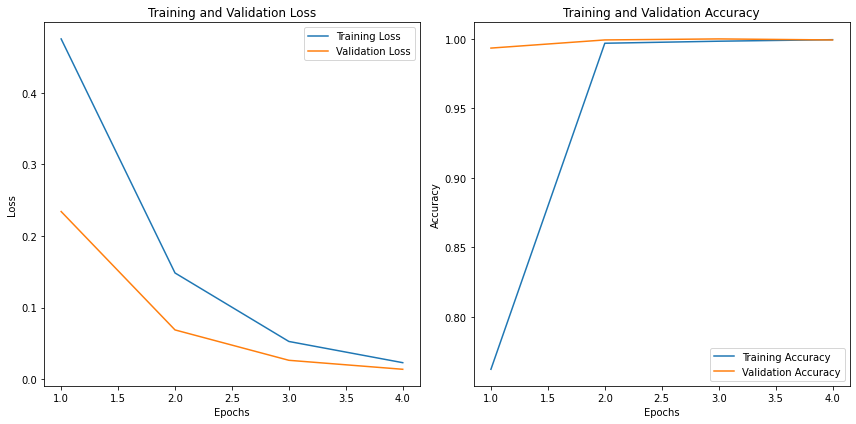

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 학습 기록 추출

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# 손실 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=loss, label='Training Loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=accuracy, label='Training Accuracy')
sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
from transformers import AutoTokenizer, TFElectraForSequenceClassification

loaded_tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
loaded_model = TFElectraForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)


def evaluate(text: str, verbose=True):
    inputs = tokenizer(text, return_tensors="tf")
    logits = loaded_model(**inputs).logits
    probabilities = tf.nn.sigmoid(logits)
    # Apply threshold of 0.5 for binary classification
    class_id = tf.where(probabilities > 0.5, 1, 0).numpy()[0]
    return class_id

normal = df[df['class']==0].sample(10)
for _, row in normal.iterrows():
    print(evaluate(row['text']))

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at _model/KoELECTRA_v3_small_binary.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [27]:
최익현 = """
후임 형사 :(익현의 머리를 때리며) 이 새끼가 뭘 잘했다고, 앉아 마!
(곧바로 수갑찬 손으로 반격하며)씨빨놈이! 쳐 돌았나? 어데서 손을 함부로 놀리노? 느그 서장 어딨어! 강서장 델꼬와!! 니 내 누군줄 아나? 내가 이 새꺄! 느그 서장이랑 마! 개섀끼..
(선임 형사) :(급하게 달려오며) 저 서..선생님.. 실례지만 저희 서장님과 관계가 어떻게..
느그 서장 남천동 살제? 어?
(선임 형사) : 예.. 예..
내가 마! 느그 서장이랑 마! 어저께도! 어? 밥 묵고! 어? 사우나도 같이 가고! 어? 마 이 개이새꺄 마 다 했어! 이 새끼들이 말이야. 개섀끼들..
"""
print(evaluate(최익현))

평경장 = """
평 경장: 기니까 네 말은 이게 9란 말이지?
고니: 네.
평 경장: 장땡이네?[5]
고니: 아니, 선생님... 그 손?
평 경장: 손이 왜?
고니: 어떻게 하신 겁니까?
평 경장: 손은 눈보다 빠르다! 무슨 패를 잡고 싶니?
고니: 일... 일땡이요.
평 경장: 아수라발발타... 아수라발발타![6]
평 경장: 돈을 벌고 싶니?
고니: 예.
평 경장: 부자가 되고 싶니?
고니: 예.
평 경장: 이거이 니 정주영이고 이병철이야!
"""

print(evaluate(평경장))

일반글 = """
흔한 커플의 카톡 대화 을 클릭해보았다.이게 웬걸 ㅋㅋ 웃기다 ㅋㅋ 

흔한 커플의 대화긴 하다.ㅋㅋ 흔한 커플의 카톡 대화 에서 보듯 ㅋㅋ 사귀다보면 ㅋㅋ 문자도 짧아진다 ㅋ

사랑한다는 말또한 줄어든다.ㅋㅋ 그건 당연한것이 아닌가?ㅋㅋ 저는 ㅋㅋ 그런말 하지도 않습니다.ㅋ

사랑은 하는데 ㅋㅋ 그런말을 못하겠더라구요 ㅋ 그래서 여자친구가 ㅋㅋ 좀 뭐라고 하지요.ㅋ

일반 커플도 다 그렇지 않나요??ㅋㅋ 사귀다 결혼해도 사귈때랑 같고. ㅋㅋ

그냥 그런게 사람 사는거 아니겠습니까??ㅋㅋㅋ 흔한 커플의 카톡 대화 에서 보니 ㅋㅋ

저 같은 사람 많더라구요.ㅎㅎ 그럼 한번 알아볼까요??ㅎㅎ

그리고 ㅋㅋ 한번 본인의 상태도 점검해 보시길 바랍니다.ㅋㅋ
"""
print(evaluate(일반글))

[1]
[1]
[0]


# 회고

1. 
2. 차이점을 알기 위해서 bert-kor-base를 먼저 실행해보자